# Notebook to show the tools that can help when comparing time series models

In [1]:
import numpy as np
import pastas as ps
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame, concat
from itertools import combinations
from pastas.plots import _table_formatter_params

%load_ext autoreload 
%autoreload 2

## Load Time Series

In [2]:
rain = read_csv("../data/rain_nb1.csv", index_col=0,
                parse_dates=True).squeeze()
evap = read_csv("../data/evap_nb1.csv", index_col=0,
                parse_dates=True).squeeze()
obs1 = read_csv("../data/head_nb1.csv", index_col=0,
               parse_dates=True).squeeze()
obs2 = read_csv("../data/nb18_head.csv", index_col=0, parse_dates=True).squeeze()

# Create three models

* Model1 has observations series 1 with has linear recharge model
* Model2 has observation series 1 with precipitation and evaporation as seperate stresses
* Model3 has observation series 2 with linear recharge model of model 1

In [3]:
ml1a = ps.Model(obs1, name="1a_exp")
sm1a = ps.RechargeModel(rain, evap, rfunc=ps.Exponential, name="recharge")
ml1a.add_stressmodel(sm1a)
ml1a.solve(report=False, noise=True)

ml1b = ps.Model(obs1, name="1b_gamma")
sm1b = ps.RechargeModel(rain, evap, rfunc=ps.Gamma, name="recharge")
ml1b.add_stressmodel(sm1b)
ml1b.solve(report=False, noise=True)

ml2 = ps.Model(obs1, name="Model2")
sm2_1 = ps.StressModel(rain, rfunc=ps.Gamma, name="Prec", settings="prec")
sm2_2 = ps.StressModel(evap, rfunc=ps.Gamma, name="Evap", settings="evap", up=False)
[ml2.add_stressmodel(x) for x in (sm2_1, sm2_2)]
# sm2 = ps.RechargeModel(rain.multiply(1e3), evap.multiply(1e3), rfunc=ps.Exponential, recharge=ps.rch.FlexModel())
# ml2.add_stressmodel(sm2)
ml2.solve(report=False, noise=True)

ml3 = ps.Model(obs2, name="Model3")
ml3.add_stressmodel(sm1a)
ml3.solve(report=False, noise=True)

INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D
INFO: Time Series rain was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D
INFO: Time Series rain was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Cannot determine frequency of series head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series rain: freq=D
INFO: Inferred frequency for time series evap: freq=D
INFO: Time

# Model Comparison Class

In [4]:
class ModelComparison:

    def __init__(self, models=None):
        """ 
        Initialize model compare class. 
        """
        self.models = models
        self.figure = None
        self.axes = None
    
    def initialize_figure(self, mosaic=None, figsize=(10, 8)):
        """
        Initialize a custom figure based on a mosaic.

        Parameters
        ----------
        mosaic : list, optional
            Subplot mosaic, by default None which uses the default mosaic.
        figsize : tuple, optional
            Figure size, by default (10, 8)
        """
        if mosaic is None:
            u_sm = self.get_unique_stressmodels(models=self.models)
            mosaic = self.get_default_mosaic(u_sm)
        
        figure, axes = plt.subplot_mosaic(mosaic, figsize=figsize)
        self.figure = figure
        self.axes = axes

    def get_unique_stressmodels(self, models=None):
        """
        Get all unique stressmodel names.
        """
        if models is None:
            models = self.models
        
        sm_unique = []
        for ml in models:
            [sm_unique.append(x) for x in ml.get_stressmodel_names() if x not in sm_unique]
        return sm_unique
    
    def get_default_mosaic(self, stressmodel_names):
        """
        Get default mosaic for matplotlib.subplot_mosaic().
        """
        mosaic = [["ossim", "ossim", "met"],
                  ["ossim", "ossim", "tab"],
                  ["residnoise", "residnoise", "tab"]]
        for sm in stressmodel_names:
            mosaic.append([f"con_{sm}", f"con_{sm}", f"step_{sm}"])
        return mosaic
    
    def get_tmin_tmax(self, models=None):
        """
        Get tmin and tmax of all models.
        """
        if models is None:
            models = self.models
        
        tmintmax = DataFrame(columns=["tmin", "tmax"], dtype="datetime64[ns]")
        for ml in models:
            tmintmax.loc[ml.name, ["tmin", "tmax"]] = [ml.get_tmin(), ml.get_tmax()]
        return tmintmax
    
    def get_parameters(self, models=None, param_selection=None, decimals=2):
        """
        Get optimal parameter values of all models in a DataFrame.
        """
        if models is None:
            models = self.models

        params = DataFrame(index=[x.name for x in models])
        for i, ml in enumerate(models):
            mlpars = ml.parameters.loc[:, "optimal"].copy()
            params.loc[ml.name, mlpars.index] = np.round(mlpars.values, decimals)
        if param_selection:
            sel = np.array([])
            for sub in param_selection:
                sel = np.append(sel, [idx for idx in params.columns if sub in idx])
            return params[sel].transpose().sort_index()
        else:
            return params.transpose()
    
    def get_diagnostics(self, models=None):
        """
        Get p-values of statistical tests in a DataFrame.
        """
        if models is None:
            models = self.models
            
        diags = DataFrame(index=[f"{x.name}_pvalue" for x in models])
        for i, ml in enumerate(models):
            mldiag = ml.stats.diagnostics()
            diags.loc[f"{ml.name}_pvalue", mldiag.index] = mldiag["P-value"].values
        return diags.transpose()

    def plot_oseries(self, axn="os"):
        """
        Plot all oseries, unless all oseries are the same.
        """
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])
        
        oseries = [ml.oseries.series for ml in self.models]               
        equals = np.array([])
        for pair in combinations(oseries, 2):
            equals = np.append(equals, np.array_equal(pair[0], pair[1]))
        if equals.all():
            self.axes[axn].plot(oseries[0].index, oseries[0].values, label=oseries[0].name, linestyle="", marker="o", color="k", markersize=3)
        else:
            for i, oseries in enumerate(oseries):
                self.axes[axn].scatter(oseries.index, oseries.values, label=oseries.name, c=f"C{i}", s=15, edgecolor="k", linewidth=0.5)

    def plot_simulation(self, axn="sim"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            simulation = ml.simulate()
            self.axes[axn].plot(simulation.index, simulation.values, label=ml.name, linestyle="-", color=f"C{i}")
    
    def plot_residuals(self, axn="resid"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            residuals = ml.residuals()
            self.axes[axn].plot(residuals.index, residuals.values, label=f"Residuals", color=f"C{i}")
                
    def plot_noise(self, axn="noise"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            noise = ml.noise()
            if noise is not None:
                self.axes[axn].plot(noise.index, noise.values, label=f"Noise", linestyle="--", color=f"C{i}")
    
    def plot_response(self, axn="step", response="step"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            smname = [x for x in ml.get_stressmodel_names() if x in axn]
            for smn in smname:
                if response == "step":
                    step = ml.get_step_response(smn, add_0=True)
                    self.axes[axn].plot(step.index, step.values, label=f"Step Response {smn}", color=f"C{i}")
                elif response == "block":
                    block = ml.get_block_response(smn)
                    self.axes[axn].semilogx(block.index, block.values, label=f"Block Response {smn}", color=f"C{i}")
            
    def plot_contribution(self, axn="con", normalized=False):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            smname = [x for x in ml.get_stressmodel_names() if x in axn]
            for smn in smname:
                for con in ml.get_contributions(split=False):
                    if smn in con.name:
                        label = f"Contribution {con.name}"
                        if normalized:
                            label = f"Contribution (Normalized) {con.name}"
                            if con.mean() < 0:
                                con -= con.max()
                            else:
                                con -= con.min()
                                
                        self.axes[axn].plot(con.index, con.values, label=label, color=f"C{i}")
    
    def plot_stress(self, axn="stress"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            smname = [x for x in ml.get_stressmodel_names() if x in axn]
            for smn in smname:
                stress = ml.get_stress(smn)
                self.axes[axn].plot(stress.index, stress.values, label=f"Stress {smn}", color=f"C{i}")
    
    def plot_autocor(self, axn="corr"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            if ml.noise() is not None:
                r = ps.stats.core.acf(ml.noise(), full_output=True)
                label = "Autocorrelation Noise"
            else:
                r = ps.stats.core.acf(ml.residuals(), full_output=True)
                label = "Autocorrelation Residuals"
            conf = r.stderr.rolling(10, min_periods=1).mean().values
            
            self.axes[axn].fill_between(r.index.days, conf, -conf, alpha=0.3, color=f"C{i}")
            self.axes[axn].vlines(r.index.days, [0], r.loc[:, "acf"].values, color=f"C{i}", label=label)

    def plot_table_params(self, axn="tab", param_selection=None):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        params = self.get_parameters(self.models, param_selection=param_selection)
        # add seperate column with parameter names
        params.loc[:, "Parameters"] = params.index
        cols = params.columns.to_list()[-1:] + params.columns.to_list()[:-1]
        params_list = params[cols].values.tolist()
        self.axes[axn].table(params_list, colLabels=cols, bbox=(0., 0., 1.0, 1.0))
        self.axes[axn].set_xticks([])
        self.axes[axn].set_yticks([])

    def plot_table_metrics(self, axn="met"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        rsq = []
        aic = []
        mlnames = []
        for i, ml in enumerate(self.models):
            rsq.append(np.round(ml.stats.rsq(), 3))
            aic.append(np.round(ml.stats.aic(), 2))
            mlnames.append(ml.name)
        aic = [f"\N{GREEK CAPITAL LETTER DELTA}AIC"] + [np.round(x-np.min(aic)) for x in aic]
        rsq = [f"R\N{SUPERSCRIPT TWO}"] + rsq
        metrics = [rsq, aic]
        self.axes[axn].table(metrics, colLabels=["Metric"]+mlnames, bbox=(0., 0., 1.0, 1.0))
        self.axes[axn].set_xticks([])
        self.axes[axn].set_yticks([])
        
    def plot_table_diagnostics(self, axn="diag"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])
        
        diags = self.get_diagnostics(self.models)
        diags.loc[:, "Test"] = diags.index
        cols = diags.columns.to_list()[-1:] + diags.columns.to_list()[:-1]
        diags_list = diags[cols].values.tolist()
        self.axes[axn].table(diags_list, colLabels=[c.replace("_", "\n") for c in cols], bbox=(0., 0., 1.0, 1.0))
        self.axes[axn].set_xticks([])
        self.axes[axn].set_yticks([])
                
    def plot(self, normalized=False, param_selection=None, grid=True, legend=True):  
        """Plot the models in a comparison plot.

        Parameters
        ----------
        normalized : bool, optional
            Normalize contributions such that minimum or maximum value is equal to zero, by default False
        param_selection : list, optional
            List of (sub)strings of which parameters to show in table, by default None
        grid : bool, optional
            Grid in each subplots, by default True
        legend : bool, optional
            Add legend in each subplot, by default True
        Returns
        -------
        matplotlib.Axes

        """
        if self.axes is None:
            self.initialize_figure()

        tmintmax = self.get_tmin_tmax(self.models)
        tmin = min(tmintmax['tmin'])
        tmax = max(tmintmax['tmax'])
        for axn in self.axes:
            if "os" in axn: # oseries
                self.plot_oseries(axn)
                self.axes[axn].set_xlim(tmin, tmax)
            if "sim" in axn: # simulation
                self.plot_simulation(axn)
                self.axes[axn].set_xlim(tmin, tmax)
            if "resid" in axn: # residuals
                self.plot_residuals(axn)
                self.axes[axn].set_xlim(tmin, tmax)
            if "noise" in axn: # noise
                self.plot_noise(axn)
                self.axes[axn].set_xlim(tmin, tmax)
            if "step" in axn: # step resonse
                self.plot_response(axn)
                self.axes[axn].set_xlim(left=0)
            if "block" in axn: # block response
                self.plot_response(axn, response="block")
            if "con" in axn: # contribution
                self.plot_contribution(axn, normalized=normalized)
                self.axes[axn].set_xlim(tmin, tmax)
            if "stress" in axn:
                self.plot_stress(axn)
                self.axes[axn].set_xlim(tmin, tmax)
            if "tab" in axn: # parameters table
                self.plot_table_params(axn, param_selection=param_selection)
            if "met" in axn: # metrics
                self.plot_table_metrics(axn)
            if "diag" in axn: # diagnostics
                self.plot_table_diagnostics(axn)
            if "corr" in axn: #autocorrelation
                self.plot_autocor(axn)
                self.axes[axn].set_xlim(left=0)

            if axn not in ("tab", "met", "diag"):
                self.axes[axn].grid(grid)
                _, l = self.axes[axn].get_legend_handles_labels()
                self.axes[axn].legend(ncol=int(np.ceil(len(l) / 2)), loc='best')
        
        self.figure.tight_layout()

        return self.axes

In [5]:
class ModelComparison2:
    def __init__(self, models=None):
        """
        Initialize model compare class.
        """
        self.models = models
        self.figure = None
        self.axes = None

    def initialize_figure(self, mosaic=None, figsize=(10, 8)):
        """
        Initialize a custom figure based on a mosaic.

        Parameters
        ----------
        mosaic : list, optional
            Subplot mosaic, by default None which uses the default mosaic.
        figsize : tuple, optional
            Figure size, by default (10, 8)
        """
        if mosaic is None:
            u_sm = self.get_unique_stressmodels(models=self.models)
            mosaic = self.get_default_mosaic(len(u_sm))

        figure, axes = plt.subplot_mosaic(mosaic, figsize=figsize)
        self.figure = figure
        self.axes = axes

    def get_unique_stressmodels(self, models=None, combine=None):
        """
        Get all unique stressmodel names.
        """
        if models is None:
            models = self.models
        sm_unique = []
        for ml in models:
            [
                sm_unique.append(x)
                for x in ml.get_stressmodel_names()
                if x not in sm_unique
            ]
        return sm_unique

    def get_default_mosaic(self, n_stressmodels):
        """
        Get default mosaic for matplotlib.subplot_mosaic().
        """
        mosaic = [
            ["sim", "sim", "met"],
            ["sim", "sim", "tab"],
            ["res", "res", "tab"],
        ]
        for i in range(n_stressmodels):
            mosaic.append([f"sm{i}", f"sm{i}", f"rf{i}"])
        return mosaic

    def get_tmin_tmax(self, models=None):
        """
        Get tmin and tmax of all models.
        """
        if models is None:
            models = self.models

        tmintmax = DataFrame(columns=["tmin", "tmax"], dtype="datetime64[ns]")
        for ml in models:
            tmintmax.loc[ml.name, ["tmin", "tmax"]] = [
                ml.get_tmin(),
                ml.get_tmax(),
            ]
        return tmintmax

    def get_parameters(
        self, models=None, paramcol="optimal", param_selection=None, decimals=2
    ):
        """
        Get parameter values of all models in a DataFrame.
        """
        if models is None:
            models = self.models

        params = concat([iml.parameters[paramcol] for iml in models], axis=1, sort=False)
        params.columns = [x.name for x in models]
        
        if param_selection:
            sel = np.array([])
            for sub in param_selection:
                sel = np.append(
                    sel, [idx for idx in params.index if sub in idx]
                )
            return params.loc[sel].sort_index().applymap(_table_formatter_params)
        else:
            return params.applymap(_table_formatter_params)

    def get_diagnostics(self, models=None):
        """
        Get p-values of statistical tests in a DataFrame.
        """
        if models is None:
            models = self.models

        diags = DataFrame(index=[f"{x.name}_pvalue" for x in models])
        for i, ml in enumerate(models):
            mldiag = ml.stats.diagnostics()
            diags.loc[f"{ml.name}_pvalue", mldiag.index] = mldiag[
                "P-value"
            ].values
        return diags.transpose()

    def plot_oseries(self, axn="sim"):
        """
        Plot all oseries, unless all oseries are the same.
        """
        if self.axes is None:
            self.initialize_figure()

        oseries = [ml.oseries.series for ml in self.models]
        equals = np.array([])
        for pair in combinations(oseries, 2):
            equals = np.append(equals, np.array_equal(pair[0], pair[1]))
        if equals.all():
            self.axes[axn].plot(
                oseries[0].index,
                oseries[0].values,
                label=oseries[0].name,
                linestyle="",
                marker="o",
                color="k",
                markersize=3,
            )
        else:
            for i, oseries in enumerate(oseries):
                self.axes[axn].scatter(
                    oseries.index,
                    oseries.values,
                    label=oseries.name,
                    c=f"C{i}",
                    s=15,
                    edgecolor="k",
                    linewidth=0.5,
                )

    def plot_simulation(self, axn="sim"):
        if self.axes is None:
            self.initialize_figure()

        for i, ml in enumerate(self.models):
            simulation = ml.simulate()
            self.axes[axn].plot(
                simulation.index,
                simulation.values,
                label=ml.name,
                linestyle="-",
                color=f"C{i}",
            )

    def plot_residuals(self, axn="res"):
        if self.axes is None:
            self.initialize_figure()

        for i, ml in enumerate(self.models):
            residuals = ml.residuals()
            self.axes[axn].plot(
                residuals.index,
                residuals.values,
                label=f"Residuals",
                color=f"C{i}",
            )

    def plot_noise(self, axn="res"):
        if self.axes is None:
            self.initialize_figure()

        for i, ml in enumerate(self.models):
            noise = ml.noise()
            if noise is not None:
                self.axes[axn].plot(
                    noise.index,
                    noise.values,
                    label=f"Noise",
                    linestyle="--",
                    color=f"C{i}",
                )

    def plot_response(self, smdict=None, axn="rf", response="step"):
        if self.axes is None:
            self.initialize_figure()

        if smdict is None:
            smdict = {i: [smn] for i, smn in enumerate(self.get_unique_stressmodels())}

        for i, ml in enumerate(self.models):
            for j, namlist in smdict.items():
                for smn in namlist:
                    # skip if contribution not in model
                    if not smn in ml.stressmodels:
                        continue
                    if response == "step":
                        step = ml.get_step_response(smn, add_0=True)
                        self.axes[f"{axn}{j}"].plot(
                            step.index,
                            step.values,
                            label=f"{smn}",
                            color=f"C{i}",
                        )
                    elif response == "block":
                        block = ml.get_block_response(smn)
                        self.axes[f"{axn}{j}"].semilogx(
                            block.index,
                            block.values,
                            label=f"{smn}",
                            color=f"C{i}",
                        )

    def plot_contribution(self, smdict=None, axn="sm", normalized=False):
        if self.axes is None:
            self.initialize_figure()

        if smdict is None:
            smdict = {i: [smn] for i, smn in enumerate(self.get_unique_stressmodels())}

        for i, ml in enumerate(self.models):
            for j, namlist in smdict.items():
                for smn in namlist:
                    if not smn in ml.stressmodels:
                        continue
                    for con in ml.get_contributions(split=False):
                        if smn in con.name:
                            label = f"{con.name}"
                            if normalized:
                                label = f"{con.name} (normalized)"
                                if con.mean() < 0:
                                    con -= con.max()
                                else:
                                    con -= con.min()

                            self.axes[f"{axn}{j}"].plot(
                                con.index, con.values, label=label, color=f"C{i}"
                            )

    def plot_stress(self, names=None, axn="stress"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])
        if names is None:
            names = self.get_unique_stressmodels()

        for i, ml in enumerate(self.models):
            for smn in names:
                stress = ml.get_stress(smn)
                self.axes[axn].plot(
                    stress.index,
                    stress.values,
                    label=f"{smn}",
                    color=f"C{i}",
                )

    def plot_acf(self, axn="acf"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        for i, ml in enumerate(self.models):
            if ml.noise() is not None:
                r = ps.stats.core.acf(ml.noise(), full_output=True)
                label = "Autocorrelation Noise"
            else:
                r = ps.stats.core.acf(ml.residuals(), full_output=True)
                label = "Autocorrelation Residuals"
            conf = r.stderr.rolling(10, min_periods=1).mean().values

            self.axes[axn].fill_between(
                r.index.days, conf, -conf, alpha=0.3, color=f"C{i}"
            )
            self.axes[axn].vlines(
                r.index.days,
                [0],
                r.loc[:, "acf"].values,
                color=f"C{i}",
                label=label,
            )

    def plot_table_params(
        self, axn="tab", paramcol="optimal", param_selection=None
    ):
        if self.axes is None:
            self.initialize_figure()

        params = self.get_parameters(
            self.models,
            param_selection=param_selection,
            paramcol=paramcol,
        )
        # add seperate column with parameter names
        params.loc[:, "Parameters"] = params.index
        cols = params.columns.to_list()[-1:] + params.columns.to_list()[:-1]
        params_list = params[cols].values.tolist()
        self.axes[axn].table(
            params_list, colLabels=cols, bbox=(0.0, 0.0, 1.0, 1.0)
        )
        self.axes[axn].set_xticks([])
        self.axes[axn].set_yticks([])

    def plot_table_metrics(self, axn="met"):
        if self.axes is None:
            self.initialize_figure()
        rsq = []
        aic = []
        mlnames = []
        for i, ml in enumerate(self.models):
            rsq.append(np.round(ml.stats.rsq(), 3))
            aic.append(np.round(ml.stats.aic(), 2))
            mlnames.append(ml.name)
        aic = [f"\N{GREEK CAPITAL LETTER DELTA}AIC"] + [
            np.round(x - np.min(aic)) for x in aic
        ]
        rsq = [f"R\N{SUPERSCRIPT TWO}"] + rsq
        metrics = [rsq, aic]
        self.axes[axn].table(
            metrics, colLabels=["Metric"] + mlnames, bbox=(0.0, 0.0, 1.0, 1.0)
        )
        self.axes[axn].set_xticks([])
        self.axes[axn].set_yticks([])

    def plot_table_diagnostics(self, axn="diag"):
        if self.axes is None:
            self.initialize_figure(mosaic=[[axn]])

        diags = self.get_diagnostics(self.models)
        diags.loc[:, "Test"] = diags.index
        cols = diags.columns.to_list()[-1:] + diags.columns.to_list()[:-1]
        diags_list = diags[cols].values.tolist()
        self.axes[axn].table(
            diags_list,
            colLabels=[c.replace("_", "\n") for c in cols],
            bbox=(0.0, 0.0, 1.0, 1.0),
        )
        self.axes[axn].set_xticks([])
        self.axes[axn].set_yticks([])

    def share_xaxes(self, axes):
        axes[0].get_shared_x_axes().join(*axes[1:])
        for iax in axes[:-1]:
            iax.set_xticklabels([])

    def share_yaxes(self, axes):
        axes[0].get_shared_y_axes().join(*axes[1:])

    def plot(
        self, normalized=False, param_selection=None, grid=True, legend=True,
        smdict=None
    ):
        """Plot the models in a comparison plot.

        Parameters
        ----------
        normalized : bool, optional
            Normalize contributions such that minimum or maximum value is equal to zero, by default False
        param_selection : list, optional
            List of (sub)strings of which parameters to show in table, by default None
        grid : bool, optional
            Grid in each subplots, by default True
        legend : bool, optional
            Add legend in each subplot, by default True
        Returns
        -------
        matplotlib.Axes

        """
        if self.axes is None:
            self.initialize_figure()

        tmintmax = self.get_tmin_tmax(self.models)
        tmin = min(tmintmax["tmin"])
        tmax = max(tmintmax["tmax"])

        # sim
        self.plot_oseries()
        self.plot_simulation()

        # res
        self.plot_residuals()
        self.plot_noise()

        # smn, rfn
        self.plot_contribution(smdict=smdict)
        self.plot_response(smdict=smdict)

        # met
        self.plot_table_metrics()

        # tab
        self.plot_table_params(param_selection=param_selection)

        xshare_left = []
        xshare_right = []
        for axn in self.axes.keys():
            if axn not in ("tab", "met"):
                self.axes[axn].grid(grid)
                _, l = self.axes[axn].get_legend_handles_labels()
                self.axes[axn].legend(
                    ncol=max([int(np.ceil(len(l))), 4]),
                    loc=(0, 1),
                    frameon=False,
                    fontsize="x-small",
                    markerscale=0.7,
                    numpoints=3,
                )
            # share x-axes
            if axn in ("sim", "res") or axn.startswith("sm"):
                xshare_left.append(self.axes[axn])
            if axn.startswith("rf"):
                xshare_right.append(self.axes[axn])
        # share x-axes
        if len(xshare_left) > 1:
            self.share_xaxes(xshare_left)
        if len(xshare_right) > 1:
            self.share_xaxes(xshare_right)

        self.figure.tight_layout()

        return self.axes


# Default compare plot

INFO: Time Series rain was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-11-17 00:00:00 with the mean value of the time series.


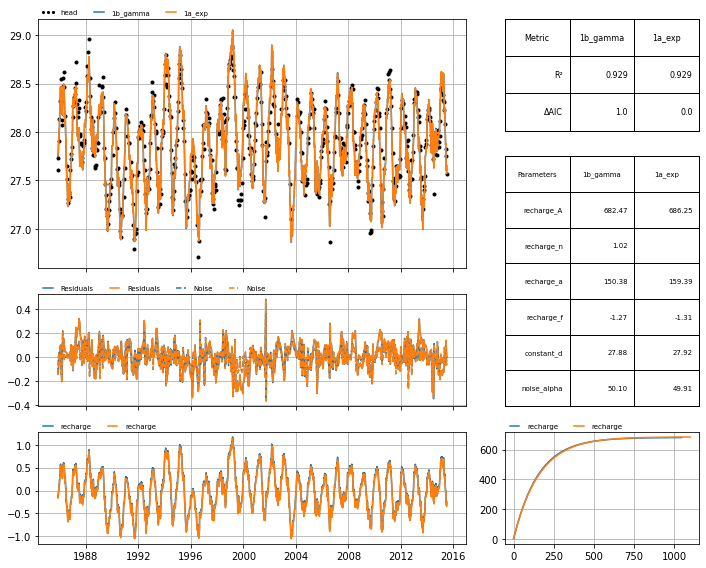

In [6]:
mlcompare = ModelComparison2(models=[ml1b, ml1a])
axes = mlcompare.plot(normalized=False)
# mlcompare.get_unique_stressmodels()
# mlcompare.initialize_figure()

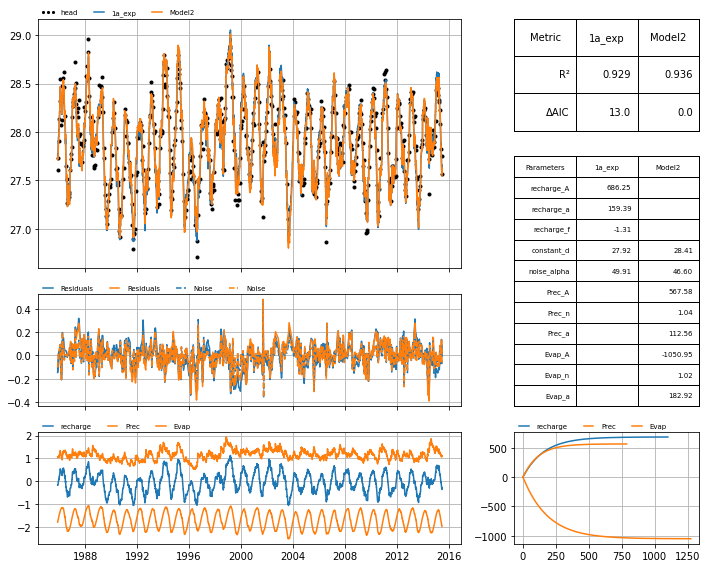

In [7]:
# models with different oseries
mlcompare = ModelComparison2(models=[ml1a, ml2])
mosaic = mlcompare.get_default_mosaic(n_stressmodels=1)
mlcompare.initialize_figure(mosaic=mosaic)
axes = mlcompare.plot(smdict={0: ["recharge", "Prec", "Evap"]})

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'right':"Stresses: ['rain', 'evap']"}>,
 <AxesSubplot:title={'center':'Step response'}, xlabel='Time [days]'>,
 <AxesSubplot:title={'left':'Model Parameters ($n_c$=5)'}>]

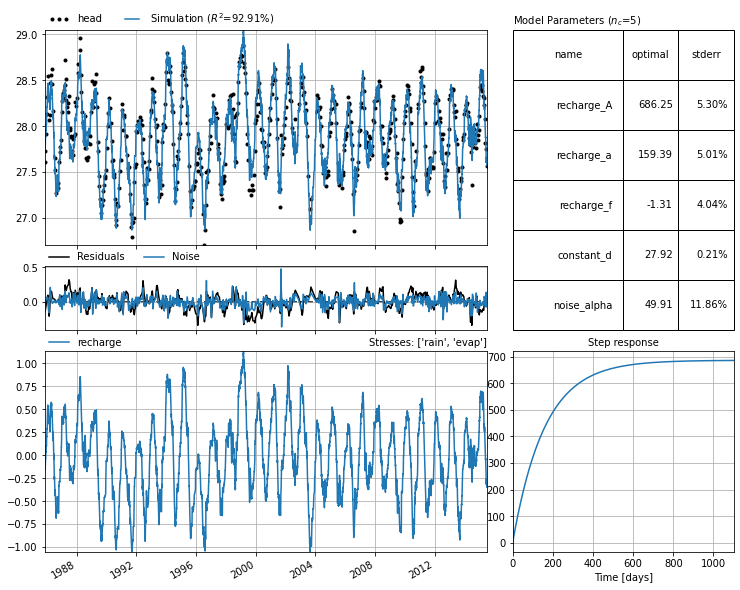

In [8]:
ml1a.plots.results()

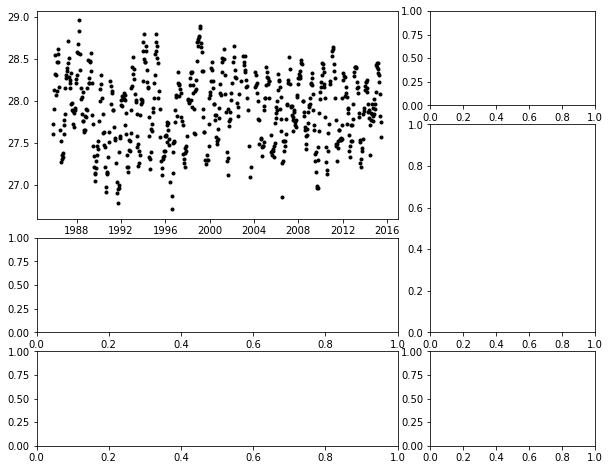

In [9]:
mlcompare = ModelComparison2(models=[ml1a, ml1b])
mlcompare.plot_oseries()

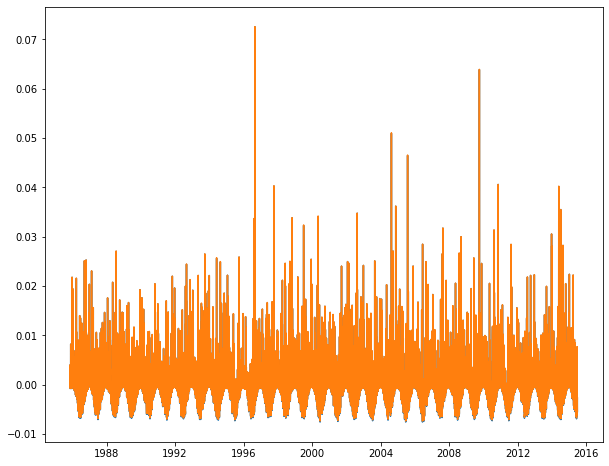

In [10]:
mlcompare = ModelComparison2(models=[ml1a, ml1b])
mlcompare.plot_stress()

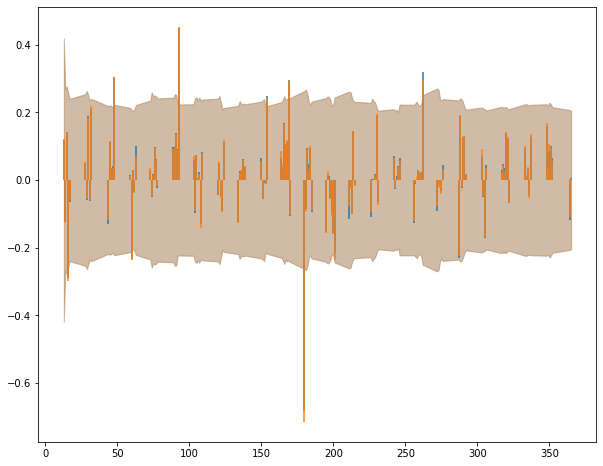

In [11]:
mlcompare = ModelComparison2(models=[ml1a, ml1b])
mlcompare.plot_acf()

# Other compare options

In [12]:
# get minimum tmin and maximum tmax
mlcompare.get_tmin_tmax()

,tmin,tmax
1a_exp,1985-11-14,2015-06-28
1b_gamma,1985-11-14,2015-06-28


In [13]:
# get table with all parameters
mlcompare.get_parameters()

,1a_exp,1b_gamma
recharge_A,686.25,682.47
recharge_a,159.39,150.38
recharge_f,-1.31,-1.27
constant_d,27.92,27.88
noise_alpha,49.91,50.10
recharge_n,,1.02


In [14]:
# get table with parameters selected by substring
mlcompare.get_parameters(param_selection=['_A'])

,1a_exp,1b_gamma
recharge_A,686.25,682.47


In [15]:
# get table with all p-values of statistical tests
mlcompare.get_diagnostics()

,1a_exp_pvalue,1b_gamma_pvalue
Shapiroo,0.00,0.00
D'Agostino,0.00,0.00
Runs test,0.64,0.27
Stoffer-Toloi,0.08,0.08


## Add custom mosaic, normalize contributions and selection of parameters

INFO: Time Series rain was extended to 2018-12-04 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 2018-12-04 00:00:00 with the mean value of the time series.
INFO: Time Series rain was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series rain was extended to 2018-12-04 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 2018-12-04 00:00:00 with the mean value of the time series.
INFO: Time Series rain was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 1975-11-17 00:00:00 with the mean value of the time series.
INFO: Time Series rain was extended to 2018-12-04 00:00:00 with the mean value of the time series.
INFO: Time Series evap was extended to 2018-12-04 00:00:00 with the mean value of the time series.
INFO: Time

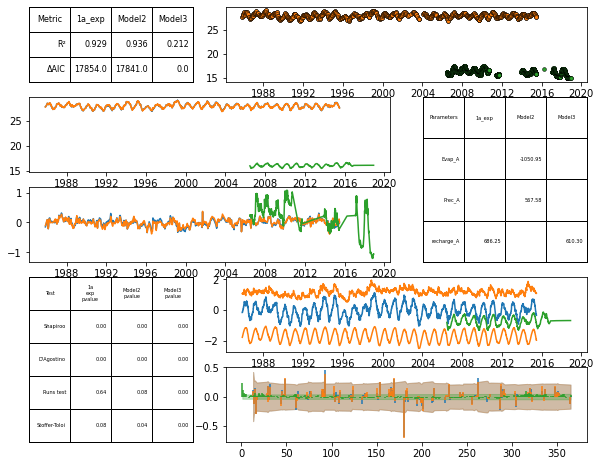

In [16]:
mosaic = [['met', 'ose', 'ose'], 
          ['sim', 'sim', 'tab'], 
          ['res', 'res', 'tab'], 
          ['dia', 'con0', 'con0'],
          ['dia', 'acf', 'acf']]
mlcompare = ModelComparison2(models=[ml1a, ml2, ml3])
mlcompare.initialize_figure(mosaic)
mlcompare.plot_table_metrics()
mlcompare.plot_oseries(axn="ose")
mlcompare.plot_simulation()
mlcompare.plot_table_params(param_selection=["_A"])
mlcompare.plot_residuals()
mlcompare.plot_table_diagnostics(axn="dia")
mlcompare.plot_contribution(smdict={0: ["Prec", "Evap", "Rech", "recharge"]}, axn="con")
mlcompare.plot_acf(axn="acf")
